In [1]:
## USE for Multi GPU Systems
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool
import cv2

import sklearn
import random
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time

import skimage

target_names = ["Knuckle", "Finger"]

In [2]:
from skimage import measure
from skimage.measure import find_contours, approximate_polygon, \
    subdivide_polygon, EllipseModel, LineModelND

In [3]:
def getEllipseParams(img):
    points = np.argwhere(img > 40)
    
    contours = skimage.measure.find_contours(img, 40)
    points_to_approx = []
    highest_val = 0
    for n, contour in enumerate(contours):
        if (len(contour) > highest_val):
            points_to_approx = contour
            highest_val = len(contour)   
    
    try:
        contour = np.fliplr(points_to_approx)
    except Exception as inst:
        return [-1, -1, -1, -1, -1]
    

    ellipse = skimage.measure.fit.EllipseModel()
    ellipse.estimate(contour)
    try:
        xc, yc, a, b, theta = ellipse.params  
    except Exception as int:
        return [-1, -1, -1, -1, -1]
    
    return [xc, yc, a, b, theta]

In [4]:
# the data, split between train and test sets
df = pd.read_pickle("DataStudyCollection/df_statistics.pkl")

lst = df.userID.unique()
np.random.seed(42)
np.random.shuffle(lst)
test_ids = lst[-5:]
train_ids = lst[:-5]

df["Set"] = "Test"
df.loc[df.userID.isin(train_ids), "Set"] = "Train"
print(train_ids, test_ids)
print(len(train_ids), ":", len(test_ids))
print(len(train_ids) / len(lst), ":", len(test_ids)/ len(lst))

#df_train = df[df.userID.isin(train_ids)]
#df_test = df[df.userID.isin(test_ids) & (df.Version == "Normal")]


[ 1  2  9  6  4 14 17 16 12  3 10 18  5] [13  8 11 15  7]
13 : 5
0.7222222222222222 : 0.2777777777777778


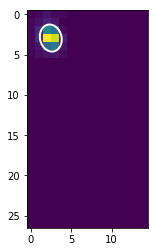

In [5]:
fig, ax = plt.subplots(1)
img = df.iloc[0].Blobs
xc, yc, a, b, theta = getEllipseParams(img)
ax.imshow(img)
e = Ellipse(xy=[xc,yc], width=a*2, height=b*2, angle=math.degrees(theta), fill=False, lw=2, edgecolor='w')
ax.add_artist(e)


In [6]:
lst = df.Blobs.apply(lambda x: getEllipseParams(x))

In [7]:
lst2 = np.vstack(lst.values)

In [8]:
lst2.shape

(618012, 5)

In [9]:
df["XC"] = lst2[:,0]
df["YC"] = lst2[:,1]
df["EllipseW"] = lst2[:,2]
df["EllipseH"] = lst2[:,3]
df["EllipseTheta"] = lst2[:,4]

In [10]:
df["Area"] = df["EllipseW"] * df["EllipseH"] * np.pi
df["AvgCapa"] = df.Blobs.apply(lambda x: np.mean(x))
df["SumCapa"] = df.Blobs.apply(lambda x: np.sum(x))

In [11]:
lst = list(range(1, df.userID.max()))
SEED = 42#448
random.seed(SEED)
random.shuffle(lst)
lst

[8, 11, 6, 7, 16, 15, 14, 10, 9, 2, 3, 13, 17, 5, 12, 1, 4]

In [12]:
dfY = df[df.Set == "Train"].copy(deep=True)
dfT = df[(df.Set == "Test") & (df.Version == "Normal")].copy(deep=True)

In [13]:
minmax = min(len(dfY[dfY.Input == "Finger"]), len(dfY[dfY.Input == "Knuckle"]))
dfX = dfY[dfY.Input == "Finger"].sample(minmax)
dfZ = dfY[dfY.Input == "Knuckle"].sample(minmax)
dfY = pd.concat([dfX,dfZ])

minmax = min(len(dfT[dfT.Input == "Finger"]), len(dfT[dfT.Input == "Knuckle"]))
dfX = dfT[dfT.Input == "Finger"].sample(minmax)
dfZ = dfT[dfT.Input == "Knuckle"].sample(minmax)
dfT = pd.concat([dfX,dfZ])

In [14]:
dfT.groupby("Input").count()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image,...,InputMethod,Set,XC,YC,EllipseW,EllipseH,EllipseTheta,Area,AvgCapa,SumCapa
Input,,,,,,,,,,,,,,,,,,,,,
Finger,9421,9421,9421,9421,9421,9421,9421,9421,9421,9421,...,9421,9421,9421,9421,9421,9421,9421,9421,9421,9421
Knuckle,9421,9421,9421,9421,9421,9421,9421,9421,9421,9421,...,9421,9421,9421,9421,9421,9421,9421,9421,9421,9421


# FEATURE SET: sum of capacitance, avg of capacitance, ellipse area, ellipse width, height and theta.

In [15]:
features = ["SumCapa", "AvgCapa", "Area", "EllipseW", "EllipseH", "EllipseTheta"]

# ZeroR

In [16]:
dfT["InputMethodPred"] = 1

In [17]:
print(confusion_matrix(dfT.InputMethod.values, dfT.InputMethodPred.values, labels=[0, 1]))
print("Accuray: %.2f" % accuracy_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print("Recall: %.2f" % metrics.recall_score(dfT.InputMethod.values, dfT.InputMethodPred.values, average="macro"))
print("Precision: %.2f" % metrics.average_precision_score(dfT.InputMethod.values, dfT.InputMethodPred.values, average="macro"))
print("F1-Score: %.2f" % metrics.f1_score(dfT.InputMethod.values, dfT.InputMethodPred.values, average="macro"))
print(classification_report(dfT.InputMethod.values, dfT.InputMethodPred.values, target_names=target_names))

[[   0 9421]
 [   0 9421]]
Accuray: 0.50
Recall: 0.50
Precision: 0.50
F1-Score: 0.33
              precision    recall  f1-score   support

     Knuckle       0.00      0.00      0.00      9421
      Finger       0.50      1.00      0.67      9421

   micro avg       0.50      0.50      0.50     18842
   macro avg       0.25      0.50      0.33     18842
weighted avg       0.25      0.50      0.33     18842



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# DecisionTreeClassifier

In [18]:
%%time
param_grid = {'max_depth': range(2,32,1),
              'min_samples_split':range(2,10,1)}
#TODO: Create Baseline for different ML stuff
clf = GridSearchCV(tree.DecisionTreeClassifier(), 
                   param_grid,
                   cv=5 , n_jobs=os.cpu_count()-2, verbose=1)
clf.fit(dfY[features].values, dfY.InputMethod.values)
print(clf.best_params_, clf.best_score_)
dfT["InputMethodPred"] = clf.predict(dfT[features].values) 

print(confusion_matrix(dfT.InputMethod.values, dfT.InputMethodPred.values, labels=[0, 1]))
print("Accuray: %.3f" % accuracy_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print("Recall: %.3f" % metrics.recall_score(dfT.InputMethod.values, dfT.InputMethodPred.values, average="macro"))
print("Precision: %.3f" % metrics.average_precision_score(dfT.InputMethod.values, dfT.InputMethodPred.values, average="macro"))
print("F1-Score: %.3f" % metrics.f1_score(dfT.InputMethod.values, dfT.InputMethodPred.values, average="macro"))
print(classification_report(dfT.InputMethod.values, dfT.InputMethodPred.values, target_names=target_names))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:   10.4s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   31.4s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:  1.3min
[Parallel(n_jobs=30)]: Done 1200 out of 1200 | elapsed:  2.4min finished


{'max_depth': 22, 'min_samples_split': 2} 0.8120637794585754
[[7409 2012]
 [3096 6325]]
Accuray: 0.73
Recall: 0.73
Precision: 0.67
F1-Score: 0.73
              precision    recall  f1-score   support

     Knuckle       0.71      0.79      0.74      9421
      Finger       0.76      0.67      0.71      9421

   micro avg       0.73      0.73      0.73     18842
   macro avg       0.73      0.73      0.73     18842
weighted avg       0.73      0.73      0.73     18842

CPU times: user 7.26 s, sys: 3.38 s, total: 10.6 s
Wall time: 2min 29s


# RandomForestClassifier

In [19]:
%%time
param_grid = {'n_estimators': range(55,64,1),
              'max_depth': range(50,70,1)}
#TODO: Create Baseline for different ML stuff
clf = GridSearchCV(ensemble.RandomForestClassifier(), 
                   param_grid,
                   cv=5 , n_jobs=os.cpu_count()-2, verbose=1)
clf.fit(dfY[features].values, dfY.InputMethod.values)
print(clf.best_params_, clf.best_score_)
dfT["InputMethodPred"] = clf.predict(dfT[features].values) 

print(confusion_matrix(dfT.InputMethod.values, dfT.InputMethodPred.values, labels=[0, 1]))
print("Accuray: %.2f" % accuracy_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print("Recall: %.2f" % metrics.recall_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print("Precision: %.2f" % metrics.average_precision_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print("F1-Score: %.2f" % metrics.f1_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print(classification_report(dfT.InputMethod.values, dfT.InputMethodPred.values, target_names=target_names))

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:  4.0min
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:  9.2min
[Parallel(n_jobs=94)]: Done 900 out of 900 | elapsed: 12.8min finished


{'max_depth': 60, 'n_estimators': 63} 0.8669582104371696
[[8175 1246]
 [2765 6656]]
Accuray: 0.79
Recall: 0.71
Precision: 0.74
F1-Score: 0.77
              precision    recall  f1-score   support

     Knuckle       0.75      0.87      0.80      9421
      Finger       0.84      0.71      0.77      9421

   micro avg       0.79      0.79      0.79     18842
   macro avg       0.79      0.79      0.79     18842
weighted avg       0.79      0.79      0.79     18842

CPU times: user 42.1 s, sys: 834 ms, total: 42.9 s
Wall time: 13min 28s


# kNN

In [20]:
%%time
param_grid = {'n_neighbors':  range(2,64,1),
              #weights': ['uniform', 'distance']
             }
#TODO: Create Baseline for different ML stuff
clf = GridSearchCV(neighbors.KNeighborsClassifier(),
                   param_grid,
                   cv=5 , n_jobs=os.cpu_count()-2, verbose=1)
clf.fit(dfY[features].values, dfY.InputMethod.values)
print(clf.best_params_, clf.best_score_)
dfT["InputMethodPred"] = clf.predict(dfT[features].values) 

print(confusion_matrix(dfT.InputMethod.values, dfT.InputMethodPred.values, labels=[0, 1]))
print("Accuray: %.2f" % accuracy_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print("Recall: %.2f" % metrics.recall_score(dfT.InputMethod.values, dfT.InputMethodPred.values, average="macro"))
print("Precision: %.2f" % metrics.average_precision_score(dfT.InputMethod.values, dfT.InputMethodPred.values, average="macro"))
print("F1-Score: %.2f" % metrics.f1_score(dfT.InputMethod.values, dfT.InputMethodPred.values, average="macro"))
print(classification_report(dfT.InputMethod.values, dfT.InputMethodPred.values, target_names=target_names))

Fitting 5 folds for each of 62 candidates, totalling 310 fits


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:   17.7s
[Parallel(n_jobs=94)]: Done 310 out of 310 | elapsed:  1.5min finished


{'n_neighbors': 2} 0.800546827088748
[[8187 1234]
 [4318 5103]]
Accuray: 0.71
Recall: 0.54
Precision: 0.67
F1-Score: 0.65
              precision    recall  f1-score   support

     Knuckle       0.65      0.87      0.75      9421
      Finger       0.81      0.54      0.65      9421

   micro avg       0.71      0.71      0.71     18842
   macro avg       0.73      0.71      0.70     18842
weighted avg       0.73      0.71      0.70     18842

CPU times: user 1.74 s, sys: 300 ms, total: 2.04 s
Wall time: 1min 30s


# SVM

In [21]:
%%time
C_range = np.logspace(1, 3,3)
gamma_range = np.logspace(-1, 1, 3)
param_grid = dict(gamma=gamma_range, C=C_range)
clf = GridSearchCV(sklearn.svm.SVC(), 
                   param_grid,
                   cv=5 , n_jobs=os.cpu_count()-2, verbose=1)
clf.fit(dfY[features].values, dfY.InputMethod.values)
print(clf.best_params_, clf.best_score_)

dfT["InputMethodPred"] = clf.predict(dfT[features].values)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  42 out of  45 | elapsed: 1056.5min remaining: 75.5min
[Parallel(n_jobs=94)]: Done  45 out of  45 | elapsed: 1080.5min finished


{'C': 10.0, 'gamma': 10.0} 0.8256943024851795
CPU times: user 2h 42min 9s, sys: 23.6 s, total: 2h 42min 33s
Wall time: 20h 43min 1s


In [22]:
print(clf.best_params_, clf.best_score_)
print(confusion_matrix(dfT.InputMethod.values, dfT.InputMethodPred.values, labels=[0, 1]))
print("Accuray: %.2f" % accuracy_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print("Recall: %.2f" % metrics.recall_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print("Precision: %.2f" % metrics.average_precision_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print("F1-Score: %.2f" % metrics.f1_score(dfT.InputMethod.values, dfT.InputMethodPred.values))
print(classification_report(dfT.InputMethod.values, dfT.InputMethodPred.values, target_names=target_names))

{'C': 10.0, 'gamma': 10.0} 0.8256943024851795
[[7106 2315]
 [2944 6477]]
Accuray: 0.72
Recall: 0.69
Precision: 0.66
F1-Score: 0.71
              precision    recall  f1-score   support

     Knuckle       0.71      0.75      0.73      9421
      Finger       0.74      0.69      0.71      9421

   micro avg       0.72      0.72      0.72     18842
   macro avg       0.72      0.72      0.72     18842
weighted avg       0.72      0.72      0.72     18842

